In [63]:
import torch
import math
import dataclasses
from enum import Enum, auto
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

In [2]:
class MultiLayerPerceptron(torch.nn.Module):
    def __init__(self, in_features: int, out_features: int, activate_fn: torch.nn.Module, n_layers: int = 4, n_units: int = 32) -> None:
        super().__init__()
        self.layers = torch.nn.ModuleList()
        for n in range(n_layers):
            self.layers.append(torch.nn.Linear(in_features if n == 0 else n_units, n_units))
            self.layers.append(activate_fn())
        self.layers.append(torch.nn.Linear(n_units, out_features))
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        for layer in self.layers:
            x = layer(x)
        return x

In [3]:
class OptionType(Enum):
    CALL = auto()
    PUT = auto()

@dataclasses.dataclass
class MarketConfig:
    risk_free_rate: float
    volatility: float

@dataclasses.dataclass
class OptionConfig:
    type: OptionType
    strike: float
    maturity: int
    spot_init: float

In [4]:
# create gbm dataset class
class GBMDataset(torch.utils.data.Dataset):
    """Geometric Brownian Motion Dataset
    
    Args:
        spot_init (float): initial spot price
        maturity (float): maturity
        n_steps (int): number of steps
        n_samples (int): number of samples
        config_market (MarketConfig): market configuration
        
    Returns:
        torch.utils.data.Dataset: dataset
    """
    def __init__(self, spot_init: float, maturity: float, n_steps: int, n_samples: int, config_market: MarketConfig) -> None:
        self.spot_init = spot_init
        self.maturity = maturity
        self.n_steps = n_steps
        self.n_samples = n_samples
        self.config_market = config_market
        self.setup()
    
    def setup(self) -> None:
        dt = self.maturity / (self.n_steps - 1)
        timesteps = torch.linspace(0, self.maturity, self.n_steps)
        dt = torch.tensor(self.maturity / self.n_steps)
        brownian_increments = torch.randn(self.n_samples, self.n_steps - 1) * torch.sqrt(dt)
        brownian_motions = torch.cat([torch.zeros(self.n_samples, 1), brownian_increments], dim=1).cumsum(dim=1)
        self.paths = self.spot_init * torch.exp((self.config_market.risk_free_rate - 0.5 * self.config_market.volatility ** 2) * timesteps + self.config_market.volatility * brownian_motions)
    
    def __len__(self) -> int:
        return self.n_samples
    
    def __getitem__(self, idx: int) -> torch.Tensor:
        return self.paths[idx]

In [40]:
def compute_hedge_pnl(
    model: torch.nn.Module,
    dataset: GBMDataset,
    config_option: OptionConfig
) -> torch.Tensor:
    DAYS_YEAR = 250
    time_to_maturity = torch.ones(dataset.n_samples) * config_option.maturity / DAYS_YEAR
    pnls = torch.zeros(dataset.n_samples)
    for day_n in range(dataset.n_steps - 1):
        inputs = torch.stack((dataset[:, day_n], time_to_maturity - day_n/DAYS_YEAR), dim=1)
        hedge_ratio = model(inputs)
        pnls += (dataset[:, day_n + 1] - dataset[:, day_n]) * hedge_ratio.squeeze()
    if config_option.type == OptionType.CALL:
        pnls -= torch.maximum(dataset[:, -1] - config_option.strike, torch.tensor(0.0))
    else:
        pnls -= torch.maximum(config_option.strike - dataset[:, -1], torch.tensor(0.0))
    return pnls

def entropic_risk_measure(pnls: torch.Tensor, alpha: float = 1.0) -> torch.Tensor:
    return (torch.logsumexp( - alpha * pnls, dim=0) - math.log(pnls.size(0))) / alpha

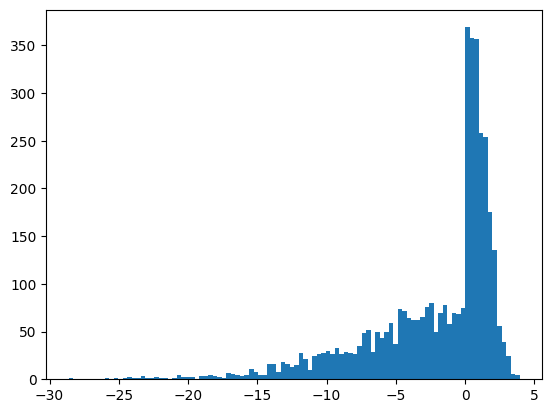

In [69]:
model = MultiLayerPerceptron(2, 1, torch.nn.GELU)
config_market = MarketConfig(0.0, 0.3)
config_option = OptionConfig(OptionType.CALL, 100.0, 10, 100.0)
dataset = GBMDataset(100.0, config_option.maturity/250, config_option.maturity+1, 4000, config_market)

# pnls before training
pnls = compute_hedge_pnl(model, dataset, config_option)
plt.hist(pnls.detach().numpy(), bins=100)
plt.show()

In [53]:
entropic_risk_measure(pnls)

tensor(27.5135, grad_fn=<DivBackward0>)

In [70]:
# train!!
# optimizer: adam, loss: entropic risk measure
# for loop with tqdm, loss value
optimizer = torch.optim.Adam(model.parameters())
n_epochs = 1000
loss_hist = []
with tqdm(range(n_epochs)) as pbar:
    for epoch in pbar:
        optimizer.zero_grad()
        pnls = compute_hedge_pnl(model, dataset, config_option)
        loss = entropic_risk_measure(pnls)
        loss.backward()
        optimizer.step()
        loss_hist.append(loss.item())
        pbar.set_postfix({'loss': loss.item()})

  0%|          | 0/1000 [00:00<?, ?it/s]

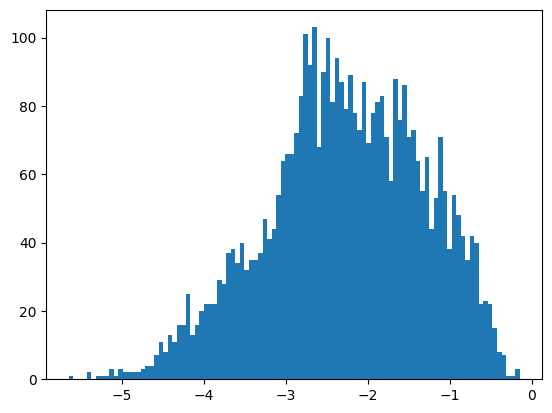

In [71]:
# pnls after training
pnls = compute_hedge_pnl(model, dataset, config_option)
plt.hist(pnls.detach().numpy(), bins=100)
plt.show()

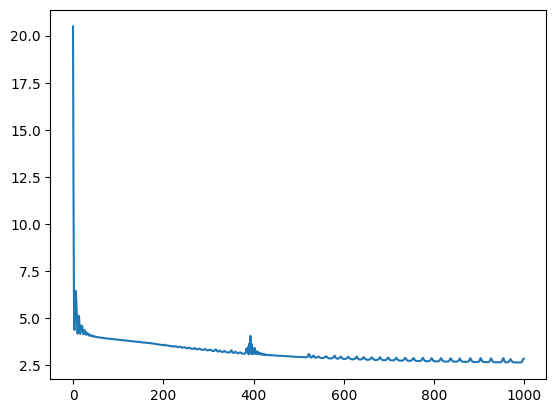

In [72]:
plt.plot(loss_hist)

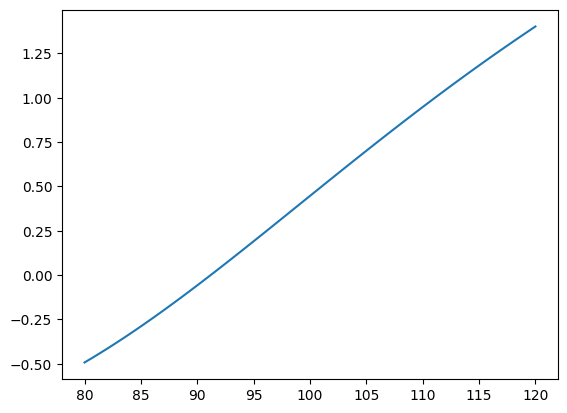

In [74]:
spots = torch.linspace(80, 120, 100)
time_to_maturity = torch.ones(100) * 10 / 250
inputs = torch.stack((spots, time_to_maturity), dim=1)
hedge_ratios = model(inputs).detach().numpy()
plt.plot(spots, hedge_ratios)

In [60]:
spots

tensor([ 80.0000,  80.4040,  80.8081,  81.2121,  81.6162,  82.0202,  82.4242,
         82.8283,  83.2323,  83.6364,  84.0404,  84.4444,  84.8485,  85.2525,
         85.6566,  86.0606,  86.4646,  86.8687,  87.2727,  87.6768,  88.0808,
         88.4848,  88.8889,  89.2929,  89.6970,  90.1010,  90.5051,  90.9091,
         91.3131,  91.7172,  92.1212,  92.5253,  92.9293,  93.3333,  93.7374,
         94.1414,  94.5455,  94.9495,  95.3535,  95.7576,  96.1616,  96.5657,
         96.9697,  97.3737,  97.7778,  98.1818,  98.5859,  98.9899,  99.3939,
         99.7980, 100.2020, 100.6061, 101.0101, 101.4141, 101.8182, 102.2222,
        102.6263, 103.0303, 103.4343, 103.8384, 104.2424, 104.6465, 105.0505,
        105.4545, 105.8586, 106.2626, 106.6667, 107.0707, 107.4747, 107.8788,
        108.2828, 108.6869, 109.0909, 109.4949, 109.8990, 110.3030, 110.7071,
        111.1111, 111.5152, 111.9192, 112.3232, 112.7273, 113.1313, 113.5354,
        113.9394, 114.3434, 114.7475, 115.1515, 115.5556, 115.95